![image](https://raw.githubusercontent.com/IBM/watson-machine-learning-samples/master/cloud/notebooks/headers/watsonx-Prompt_Lab-Notebook.png)
# Use watsonx to tune Meta `llama-2-13b-chat` model with Consumer Financial Protection Bureau document

#### Disclaimers

- Use only Projects and Spaces that are available in watsonx context.


## Notebook content

This notebook contains the steps and code to demonstrate support of prompt tuning in watsonx.

Some familiarity with Python is helpful. This notebook uses Python 3.10.


## Learning goal

The goal of this notebook is to demonstrate how to:
- upload of dataset with prompts to container (project)
- finding best tuning parameters (hyper-parameters optimization)
- trigger prompt tuning process
- review of prompt tuning process details/results
- deploy prompt-tuned model/asset
- evaluation (via inference) of prompt-tuned model/asset


## Contents

This notebook contains the following parts:

- [Setup](#setup)
- [Data loading](#data_loading)
- [Initialize experiment](#initialize)
- [Hyper-parameters optimization](#hpo)
- [Run Prompt Tuning](#run_tuning)
- [Prompt Tuning details](#run_details)
- [Deploy](#deploy)
- [Foundation Models Inference](#models_inference)
- [Analyze the satisfaction](#predict)
- [Summary and next steps](#summary)

<a id="setup"></a>
## Set up the environment

Before you use the sample code in this notebook, you must perform the following setup tasks:

-  Create a <a href="https://cloud.ibm.com/catalog/services/watson-machine-learning" target="_blank" rel="noopener no referrer">Watson Machine Learning (WML) Service</a> instance (a free plan is offered and information about how to create the instance can be found <a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/admin/create-services.html?context=wx&audience=wdp" target="_blank" rel="noopener no referrer">here</a>).

### Install and import the `datasets` and dependencies

In [15]:
!pip install ibm-watsonx-ai | tail -n 1
!pip install scikit-learn | tail -n 1
!pip install matplotlib | tail -n 1
!pip install wget | tail -n 1



zsh:1: command not found: pip


zsh:1: command not found: pip
zsh:1: command not found: pip
zsh:1: command not found: pip


In [47]:
import ssl

ssl._create_default_https_context = ssl._create_stdlib_context

In [48]:
import os
current_path = os.getcwd()
current_path

'/Users/mohamedgamal/Documents/GitHub/Bootcamp/self-guided-labs/Day-1/lab-03-Prompt-Tuning-for-Classification  '

### Watsonx API connection
This cell defines the credentials required to work with watsonx API for Foundation
Model inferencing.

**Action:** Provide the IBM Cloud user API key. For details, see <a href="https://cloud.ibm.com/docs/account?topic=account-userapikey&interface=ui" target="_blank" rel="noopener no referrer">documentation</a>.

In [49]:
import getpass

credentials = {
    "url": "https://us-south.ml.cloud.ibm.com",
    "apikey": "5cV3paCw4FU5TBSWMQ3wg_-B9mWN89w87UOLv07WeSNk"
}

### Defining the project id
The Foundation Model requires project id that provides the context for the call. We will obtain the id from the project in which this notebook runs. Otherwise, please provide the project id.

In [68]:
#import os

#try:
#    project_id = os.environ["PROJECT_ID"]
#except KeyError:
#    project_id = input("Please enter your project_id (hit enter): ")

project_id= "a45fe9fb-aa54-4501-ad42-82b1e3511292"

Create an instance of APIClient with authentication details.

In [69]:
from ibm_watsonx_ai import APIClient

client = APIClient(credentials)

To be able to interact with all resources available in Watson Machine Learning, you need to set **project_id** which you will be using.

In [70]:
client.set.default_project(project_id)

'SUCCESS'

<a id="data_loading"></a>
## Data loading

This example uses the Consumer Financial Protection Bureau training dataset. 

In [76]:
filename = '600c_compliants_classification_training_examples.json'

Download training data from git repository and create data assets.

In [77]:

       
asset_details = client.data_assets.create(name=filename, file_path=filename)
asset_id = client.data_assets.get_id(asset_details)
asset_id
 

Creating data asset...
SUCCESS


'9d0a7d8d-d72c-4da2-be11-342999888259'

Define connection information to training data.

In [78]:
from ibm_watsonx_ai.helpers import DataConnection

data_conn = DataConnection(data_asset_id=asset_id)

<a id="initialize"></a>
## Initialize experiment

In [79]:
from ibm_watsonx_ai.experiment import TuneExperiment

experiment = TuneExperiment(credentials, project_id=project_id)

All avaliable tasks are presented under `Tasks` Enum

In [80]:
{task.name: task.value for task in experiment.Tasks}

{'QUESTION_ANSWERING': 'question_answering',
 'SUMMARIZATION': 'summarization',
 'RETRIEVAL_AUGMENTED_GENERATION': 'retrieval_augmented_generation',
 'CLASSIFICATION': 'classification',
 'GENERATION': 'generation',
 'CODE_GENERATION_AND_CONVERSION': 'code',
 'EXTRACTION': 'extraction',
 'TRANSLATION': 'translation'}

<a id="hpo"></a>
## Hyper-parameters optimization

The goal of hyper-parameters optimization is to find the best `learning_rate` value yielding the lowest loss. The search space can be extended to other parameters like `num_epochs` or `batch_size`.
**Hint:** To execute the code change the cell type to Code and remove markdown marks. Note that HPO takes significant time and resources.


```python
!pip install scikit-optimize | tail -n 1
```

### Train function
Let's define the `train_evaluate` function that will accepts set of parameters from SEARCH dict and return the loss value.
In addition, we will measure the elapsed time. To speed up the HPO time we will use only 3 epochs.

```python
import time

def train_evaluate(search_params):
    prompt_tuner = experiment.prompt_tuner(name="Prompt tuning with HPO - " + str(search_params),
                                           base_model='meta-llama/llama-2-13b-chat',
                                           task_id=experiment.Tasks.CLASSIFICATION,
                                           tuning_type=experiment.PromptTuningTypes.PT,
                                           num_epochs=3,
                                           batch_size=8,
                                           max_input_tokens=256,
                                           max_output_tokens=20,
                                           verbalizer="Including narratives choice the best match product with the items from the list: 'credit_card', 'debt_collection', 'mortgages_and_loans', 'credit_reporting', 'retail_banking'. Input: {{input}} Output: ",
                                           auto_update_model=False,
                                           **search_params
                                           )

    tuning_details = prompt_tuner.run(training_data_references=[data_conn], background_mode=True)
    print(f"Starting the tune...")
    print(f"hyper-parameters", str(search_params))
    start = time.time()

    while prompt_tuner.get_run_status() not in ['failed', 'canceled', 'completed']:
        tuning_details = prompt_tuner.get_run_details()
        time.sleep(10)
    end = time.time() - start

    if prompt_tuner.get_run_status() in ['failed', 'canceled']:
        print("Model tuning failed or halted")
        return 10

    try:
       loss = prompt_tuner.summary().loss.values[0]
    except:
        loss = 10

    print(prompt_tuner.get_run_status(), 'loss: ',  loss, ' | run time', end)
    return loss
```

### Search space and optimization
In next step let's define the search space for `learning_rate` and objective function.

```python
import skopt

SPACE = [
    skopt.space.Real(0.001, 0.09, name='learning_rate', prior='log-uniform')
]

@skopt.utils.use_named_args(SPACE)
def objective(**params):
    return train_evaluate(params)

results = skopt.forest_minimize(objective, SPACE, n_calls=10)
best_loss = results.fun
best_params = results.x

print('best result: ', best_loss)
print('best parameters: ', best_params)
```

<a id="run_tuning"></a>
## Run Prompt Tuning

Run a prompt tuning process of foundation model on top of the training data referenced by DataConnection (tuning may take some time).

Define `prompt_tuner` parameters. In the example below the `learning_rate` value was established using the HPO runs described above.

**Action:** For parameters details, see <a href="https://ibm.github.io/watsonx-ai-python-sdk/tune_experiment.html#ibm_watsonx_ai.experiment.fm_tune.TuneExperiment.prompt_tuner" target="_blank" rel="noopener no referrer">documentation</a>.

In [138]:
#prompt_tuner = experiment.prompt_tuner(name="Flan prompt tuning1 - python SDK",
#                                       task_id=experiment.Tasks.CLASSIFICATION,
#                                       base_model='google/flan-t5-xl',
#                                       accumulate_steps=32,
#                                       batch_size=8,
#                                       learning_rate=0.1,
#                                       max_input_tokens=256,
#                                       max_output_tokens=10,
#                                       num_epochs=20,
#                                       tuning_type=experiment.PromptTuningTypes.PT,
#                                       verbalizer="classify { 'credit_card', 'debt_collection','mortgages_and_loans', 'retail_banking','credit_reporting' } Input: {{input}} Output:",
#                                       auto_update_model=True
                                       )

You can review previous set parameters

In [139]:
prompt_tuner.get_params()

{'base_model': {'model_id': 'google/flan-t5-xl'},
 'accumulate_steps': 32,
 'batch_size': 8,
 'learning_rate': 0.1,
 'max_input_tokens': 256,
 'max_output_tokens': 10,
 'num_epochs': 20,
 'task_id': 'classification',
 'tuning_type': 'prompt_tuning',
 'verbalizer': "classify { 'credit_card', 'debt_collection','mortgages_and_loans', 'retail_banking','credit_reporting' } Input: {{input}} Output:",
 'name': 'Flan prompt tuning1 - python SDK',
 'description': 'Prompt tuning with SDK',
 'auto_update_model': True,
 'group_by_name': False}

By changing the `background_mode` parameter to `True`, the prompt tuning process will run in the background.

In [140]:
tuning_details1 = prompt_tuner.run(training_data_references=[data_conn], background_mode=False)



##############################################

Running 'd52277b6-62a4-4e3d-964d-ad670f5989b3'

##############################################


pending.........
running...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
completed
Training of 'd52277b6-62a4-4e3d-964d-ad670f5989b3' finished successfully.


<a id="run_details"></a>
## Prompt Tuning details

Check status/state of initialized Prompt Tuning run if ran in background mode or when process finish if background mode is off.

In [141]:
prompt_tuner.get_run_status()

'completed'

In [142]:
# using datetime module
import datetime;
 
# ct stores current time
ct = datetime.datetime.now()
print("current time:-", ct)
 
# ts store timestamp of current time
ts = ct.timestamp()
print("timestamp:-", ts)

current time:- 2024-05-02 20:26:39.426193
timestamp:- 1714667199.426193


Let's summarize the run.

In [143]:
prompt_tuner.summary()

,Enhancements,Base model,Auto store,Epochs,loss
Model Name,,,,,
model_d52277b6-62a4-4e3d-964d-ad670f5989b3,[prompt_tuning],google/flan-t5-xl,True,20,0.248812


Plot learning curves.

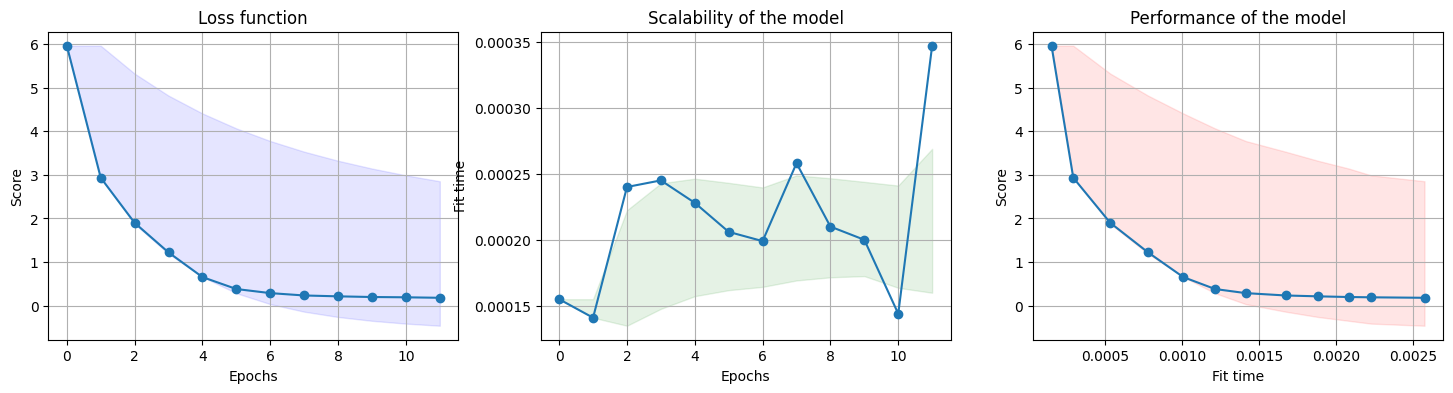

In [ ]:
prompt_tuner.plot_learning_curve()

<a id="deploy"></a>
## Deploy

You can specify `model_id` from tuning details.

In [144]:
model_id = None
#model_id='1a117594-53c6-4618-a12c-f371d086360a'

if 'model_id' in tuning_details1.get('entity', {}):
    model_id = tuning_details1['entity']['model_id']
model_id

'35dad547-8044-418a-b8c7-44ca54f7fd16'

Create online deployment for published model.

In [145]:
from datetime import datetime
meta_props = {
    client.deployments.ConfigurationMetaNames.NAME: "PT DEPLOYMENT SDK - project",
    client.deployments.ConfigurationMetaNames.ONLINE: {},
    client.deployments.ConfigurationMetaNames.SERVING_NAME : f"pt_sdk_deployment_{datetime.utcnow().strftime('%Y_%m_%d_%H%M%S')}"
}
deployment_details = client.deployments.create(model_id, meta_props)

/var/folders/b6/2mvpry951b7_ftfm7pxtb_cw0000gn/T/ipykernel_67835/2420237360.py:5: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  client.deployments.ConfigurationMetaNames.SERVING_NAME : f"pt_sdk_deployment_{datetime.utcnow().strftime('%Y_%m_%d_%H%M%S')}"




#######################################################################################

Synchronous deployment creation for uid: '35dad547-8044-418a-b8c7-44ca54f7fd16' started

#######################################################################################


initializing...................
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='8cb2fde7-3c2f-44f8-b676-77c2ffa45998'
------------------------------------------------------------------------------------------------




Additionally you can get deployment details by printing `deployment_details`

In [146]:
deployment_details

{'entity': {'asset': {'id': '35dad547-8044-418a-b8c7-44ca54f7fd16'},
  'base_model_id': 'google/flan-t5-xl',
  'custom': {},
  'deployed_asset_type': 'prompt_tune',
  'name': 'PT DEPLOYMENT SDK - project',
  'online': {'parameters': {'serving_name': 'pt_sdk_deployment_2024_05_03_051451'}},
  'project_id': 'a45fe9fb-aa54-4501-ad42-82b1e3511292',
  'status': {'inference': [{'url': 'https://us-south.ml.cloud.ibm.com/ml/v1/deployments/pt_sdk_deployment_2024_05_03_051451/text/generation',
     'uses_serving_name': True},
    {'sse': True,
     'url': 'https://us-south.ml.cloud.ibm.com/ml/v1/deployments/pt_sdk_deployment_2024_05_03_051451/text/generation_stream',
     'uses_serving_name': True},
    {'url': 'https://us-south.ml.cloud.ibm.com/ml/v1/deployments/8cb2fde7-3c2f-44f8-b676-77c2ffa45998/text/generation'},
    {'sse': True,
     'url': 'https://us-south.ml.cloud.ibm.com/ml/v1/deployments/8cb2fde7-3c2f-44f8-b676-77c2ffa45998/text/generation_stream'}],
   'serving_urls': ['https://us-s

You can specify `deployment_id` from deployment details.

In [147]:
deployment_id = deployment_details['metadata']['id']
deployment_id

'8cb2fde7-3c2f-44f8-b676-77c2ffa45998'

<a id="models_inference"></a>
## Foundation Models Inference on `watsonx.ai`

Provide a set of model parameters.

In [101]:
from ibm_watsonx_ai.metanames import GenTextParamsMetaNames as GenParams

generate_params = {
    GenParams.MAX_NEW_TOKENS: 20,
    GenParams.STOP_SEQUENCES: ["\n\n"]
}

Initialize the `ModelInference` class.

In [102]:
from ibm_watsonx_ai.foundation_models import ModelInference

tuned_model = ModelInference(
    deployment_id=deployment_id,
    params=generate_params,
    api_client=client
)

Alternatively you can use `credentials` and `project_id` to initialize the `ModelInference` class.

```
tuned_model = ModelInference(
    deployment_id=deployment_id,
    params=generate_params,
    credentials=credentials,
    project_id=project_id
)

```

Get deployment model inference details.

In [103]:
tuned_model.get_details()

{'entity': {'asset': {'id': 'b7d47f71-5aa9-4299-ad47-5f513ca871a4'},
  'base_model_id': 'google/flan-t5-xl',
  'custom': {},
  'deployed_asset_type': 'prompt_tune',
  'name': 'PT DEPLOYMENT SDK - project',
  'online': {'parameters': {'serving_name': 'pt_sdk_deployment_2024_05_02_115951'}},
  'project_id': 'a45fe9fb-aa54-4501-ad42-82b1e3511292',
  'status': {'inference': [{'url': 'https://us-south.ml.cloud.ibm.com/ml/v1/deployments/pt_sdk_deployment_2024_05_02_115951/text/generation',
     'uses_serving_name': True},
    {'sse': True,
     'url': 'https://us-south.ml.cloud.ibm.com/ml/v1/deployments/pt_sdk_deployment_2024_05_02_115951/text/generation_stream',
     'uses_serving_name': True},
    {'url': 'https://us-south.ml.cloud.ibm.com/ml/v1/deployments/770596a8-30cd-49fa-b301-371c78f86699/text/generation'},
    {'sse': True,
     'url': 'https://us-south.ml.cloud.ibm.com/ml/v1/deployments/770596a8-30cd-49fa-b301-371c78f86699/text/generation_stream'}],
   'serving_urls': ['https://us-s

Analyze the product class for a sample prompt.

In [104]:
response = tuned_model.generate_text(prompt="Including narratives choice the best match product with the items from the list: 'credit_card', 'debt_collection', 'mortgages_and_loans', 'credit_reporting', 'retail_banking'.\nComment: hi landed job reside ca needed room rent found place rent paid deposit dollar however position going didnt work longer needed rent place bay asked landlord refund security deposit refused told called back wellsfargo disputed transaction recently noticed card reversal checking account got charged amount dollar called bank werent able refund money also emailed landlord asking refund money ten day passed still response hope cfpb take action successfully resolve issue thank\nProduct:\n")
response

'credit_card'

<a id="predict"></a>
## Analyze the product classes.

Download and prepare the `cfpb_test` dataset.

In [105]:
import pandas as pd

filename = 'cfpb_test.json'
url = "https://raw.github.com/IBM/watson-machine-learning-samples/master/cloud/data/prompt_tuning/cfpb_test.json"
if not os.path.isfile(filename):
    wget.download(url)
    
data = pd.read_json(filename)

In [106]:
prompts = list(data.input)
products = list(data.output)

In [107]:
prompts_batch = ["\n".join([prompt]) for prompt in prompts]

### Calculate the accuracy of tuned model

In [108]:
tuned_model_results = tuned_model.generate_text(prompt=prompts_batch)

Let's strip whitespaces from the generated text to have reliable accuracy calculated.

In [110]:
tuned_model_results = [x.strip() for x in tuned_model_results]

In [109]:
from sklearn.metrics import accuracy_score

print(f'accuracy_score: {accuracy_score(products, tuned_model_results)}')

accuracy_score: 0.6966666666666667


### Calculate the accuracy of base model

Initialize the `ModelInference` class with base model.

In [46]:
base_model = ModelInference(
    model_id='meta-llama/llama-2-13b-chat',
    params=generate_params,
    api_client=client
)

In [210]:
base_model_results = base_model.generate_text(prompt=prompts_batch)

Let's strip whitespaces from the generated text to have reliable accuracy calculated.

In [ ]:
base_model_results = [x.strip() for x in base_model_results]

In [73]:
from sklearn.metrics import accuracy_score

print(f'base model accuracy_score: {accuracy_score(products, base_model_results)}')

base model accuracy_score: 0.0033333333333333335


<a id="summary"></a>
## Summary and next steps

 You successfully completed this notebook!
 
 You learned how to use prompt tuning in watsonx for analyze the product classes for a sample prompts.
 
Check out our _<a href="https://ibm.github.io/watsonx-ai-python-sdk/samples.html" target="_blank" rel="noopener no referrer">Online Documentation</a>_ for more samples, tutorials, documentation, how-tos, and blog posts. 

### Authors: 

**Lukasz Cmielowski**, Senior Technical Staff Member at Watson Machine Learning,

**Mateusz Szewczyk**, Software Engineer at Watson Machine Learning.

Copyright © 2024 IBM. This notebook and its source code are released under the terms of the MIT License.